### Simulation Garch (1,1)


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as opt

#### GARCH simulation

In [3]:



def simuler_ret(T , params):
    #Nombre d'obervation généré
    #Model the conditional variance

    #Initialise les paramètres
    alpha_0 = params[0]
    alpha_1 = params[1]
    beta = params[2]

    #Initialise nos variables
    V = np.random.normal(0, 1, T) #Return standardisé
    U = np.zeros(T) #Return non standarisé qu'on veut générer
    sig = np.zeros(T)


    #Initialisation au temps = 0, Garch(1,1)
    sig[0] = np.sqrt(alpha_0 / (1 - alpha_1 - beta)) #Écart type
    U[0] = V[0]*sig[0]

    for t in range(1,T): 
        sig[t] = np.sqrt(alpha_0 + alpha_1*U[t-1]**2 + beta*sig[t-1]**2)
        U[t] = V[t]*sig[t]
    


    result = pd.DataFrame({"U": U, "sig":sig, "V": V})
    
    return result


In [4]:

############# Define GARCH recursion ###################
def generer_garch(alpha_0, alpha_1, beta, U):
    
    T = len(U) 
    sigma_2 = np.zeros(T)
    
    
    sigma_2[0] = alpha_0 / (1 - alpha_1 - beta)
    
    for i in range(1, T):
        sigma_2[i] = alpha_0 + alpha_1 * U[i-1]**2 + beta * sigma_2[i-1]
        
    return sigma_2



############# Define GARCH log-Likelihood ###################
def garch_loglike(params, U):
    
    
    alpha_0 = params[0]
    alpha_1 = params[1]
    beta = params[2]
    
    
    sigma_2 = generer_garch(alpha_0, alpha_1, beta, U)
    
    LogL = -np.sum(-np.log(sigma_2) - U**2 / sigma_2 )
    
    return LogL
    




 

In [5]:
############# Maximization ###################
        
#Contrainte 
def cons1(params): #optimiser par un paramètre
    alpha_1 = params[1]
    beta = params[2]
    return 1- alpha_1 - beta #Inequality, on veut que ça reste > 0

#On déclare la contrainte
cons = {"type": "ineq", "fun": cons1}
bounds = ((0.01,None),(0.01,1),(0.01,1))
vP0 = (0.1, 0.1, 0.8)

#On simule les returns 
params = [0.2, 0.10, 0.88]

#On utilise notre fonction pour simuler
T=1000
result = simuler_ret( T , params)
U = result["U"]

#On utilise la librairie pour optimiser (À voir l'algorithme sélectionné)
res = opt.minimize(garch_loglike, vP0, args= U,
                   bounds = bounds,
                   method="SLSQP",
                   options = {"disp" : False})

/var/folders/hv/1_92kz110w572ncggsb_c81c0000gp/T/ipykernel_49567/4220165512.py:28: RuntimeWarning: invalid value encountered in log
  LogL = -np.sum(-np.log(sigma_2) - U**2 / sigma_2 )
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/optimize/_optimize.py:284: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


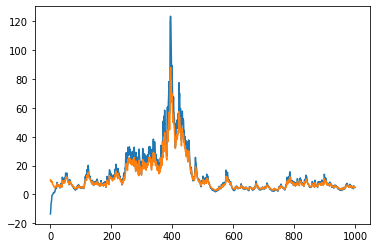

In [6]:
############ On plot ##############

#Assignation du résultat de l'optimisateur
alpha_0est = res.x[0]
alpha_1est = res.x[1]
beta_est = res.x[2]


#On veut vérifier la volatilité conditionnelle trouvé par le solveur
sigma_2 = generer_garch(alpha_0est, alpha_1est, beta_est, U)
sig_2 = result["sig"]**2 #La volatilité conditionnelle généré

#On compare la valeur estimé et la vraie
plt.plot(sigma_2)
plt.plot(sig_2)

In [7]:
############# Fonction Minimiser ###################
#Contrainte 
def cons1(params): #optimiser par un paramètre
    alpha_1 = params[1]
    beta = params[2]
    return 1- alpha_1 - beta #Inequality, on veut que ça reste > 0


def minimiser(T, params): #Je connais les paramètres et je crée une simulation pour savoir si l'optimsateur fonctionne
    #On déclare la contrainte
    #cons = {"type": "ineq", "fun": cons1}
    bounds = ((0.0001,None),(0.0001,1),(0.0001,1))
    vP0 = (0.1, 0.1, 0.8)

    result = simuler_ret(T, params)
    ret = result["U"]

    #On utilise la librairie pour optimiser (À voir l'algorithme sélectionné)
    res = opt.minimize(garch_loglike, vP0, args= ret,
                    bounds = bounds,
                    options = {"disp" : False})
    return res

In [8]:
######## Monte Carlo #############


params = [0.2, 0.10, 0.88]

#Nombre de donnée
T = [1000, 2000, 3000]

#Nombre d'estimation
test = 20

df = pd.DataFrame(columns=["T","alpha_0est","alpha_1est", "beta_est" ])
for i in range(len(T)):
    
    for x in range(test):
        
        tmp1 = minimiser(T[i], params).x
        new_row = {"T": T[i] ,"alpha_0est": tmp1[0], "alpha_1est": tmp1[1], "beta_est" : tmp1[2]}
        df = df.append(new_row, ignore_index=True )
    

/var/folders/hv/1_92kz110w572ncggsb_c81c0000gp/T/ipykernel_49567/2934929805.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True )
/var/folders/hv/1_92kz110w572ncggsb_c81c0000gp/T/ipykernel_49567/4220165512.py:28: RuntimeWarning: invalid value encountered in log
  LogL = -np.sum(-np.log(sigma_2) - U**2 / sigma_2 )
/var/folders/hv/1_92kz110w572ncggsb_c81c0000gp/T/ipykernel_49567/2934929805.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True )
/var/folders/hv/1_92kz110w572ncggsb_c81c0000gp/T/ipykernel_49567/2934929805.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True )
/var/folders/hv/1_92kz110w572

0.24575721953155946
0.10897168866775142
0.8645207100787902
0.19826250138291718
0.09808558444773371
0.8811059215140521


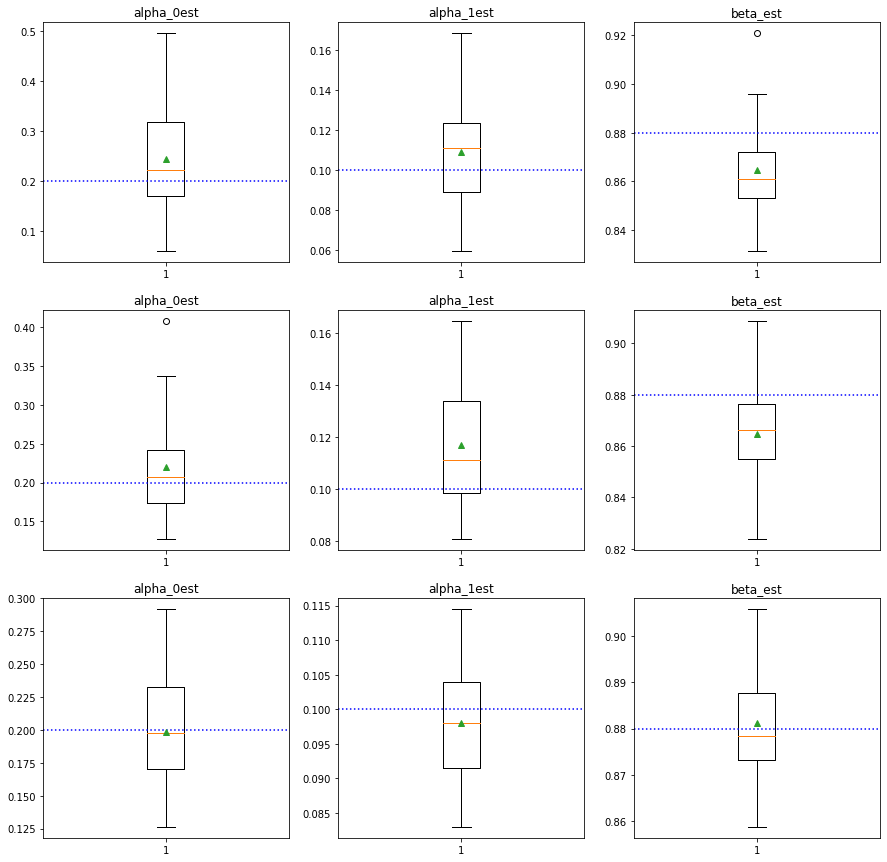

In [13]:
## Séparer les données et faire un boxplot



df1000 = df[df["T"] == T[0]]
df2000 = df[df["T"] == T[1]]
df3000 = df[df["T"] == T[2]]

fig, axs = plt.subplots(3,3, figsize=(15, 15))


axs[0, 0].boxplot(df1000["alpha_0est"], showmeans=True)
axs[0, 0].set_title('alpha_0est')
axs[0, 0].axhline(y= params[0], color = 'b', linestyle = ':')

axs[0, 1].boxplot(df1000["alpha_1est"], showmeans=True)
axs[0, 1].set_title('alpha_1est')
axs[0, 1].axhline(y= params[1], color = 'b', linestyle = ':')

axs[0, 2].boxplot(df1000["beta_est"], showmeans=True)
axs[0, 2].set_title('beta_est')
axs[0, 2].axhline(y= params[2], color = 'b', linestyle = ':')

axs[1, 0].boxplot(df2000["alpha_0est"], showmeans=True)
axs[1, 0].set_title('alpha_0est')
axs[1, 0].axhline(y= params[0], color = 'b', linestyle = ':')

axs[1, 1].boxplot(df2000["alpha_1est"], showmeans=True)
axs[1, 1].set_title('alpha_1est')
axs[1, 1].axhline(y= params[1], color = 'b', linestyle = ':')

axs[1, 2].boxplot(df2000["beta_est"], showmeans=True)
axs[1, 2].set_title('beta_est')
axs[1, 2].axhline(y= params[2], color = 'b', linestyle = ':')

axs[2, 0].boxplot(df3000["alpha_0est"], showmeans=True)
axs[2, 0].set_title('alpha_0est')
axs[2, 0].axhline(y= params[0], color = 'b', linestyle = ':')

axs[2, 1].boxplot(df3000["alpha_1est"], showmeans=True)
axs[2, 1].set_title('alpha_1est')
axs[2, 1].axhline(y= params[1], color = 'b', linestyle = ':')

axs[2, 2].boxplot(df3000["beta_est"], showmeans=True)
axs[2, 2].set_title('beta_est')
axs[2, 2].axhline(y= params[2], color = 'b', linestyle = ':')


print(df1000["alpha_0est"].mean())
print(df1000["alpha_1est"].mean())
print(df1000["beta_est"].mean())

print(df3000["alpha_0est"].mean())
print(df3000["alpha_1est"].mean())
print(df3000["beta_est"].mean())

